In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import librosa
import numpy as np
import matplotlib.pyplot as plt

import random


In [2]:
#IMPORT OUR LIBRARIES
import dataloader
import best_classif_model

cudnn.benchmark = True


In [3]:
#LOAD DATASET
dataset = dataloader.MusicDataset('Data/genres_original','Data/features_30_sec.csv')

Loading:  50  items from dataset
Loading:  100  items from dataset
Loading:  150  items from dataset
Loading:  200  items from dataset
Loading:  250  items from dataset
Loading:  300  items from dataset


In [4]:
#RESNET BLOCK

class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)

In [5]:
#MODEL - GENERATOR
class Generator(nn.Module):
    
    def __init__(self, num_classes=8, conv_dim=64, repeat_num=6):
        super(Generator, self).__init__()
        
        c_dim = num_classes
        
        #upp sampling
        layers = []
        layers.append(nn.Conv2d(1+c_dim, conv_dim, kernel_size=(3, 9), padding=(1, 4), bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=(4, 8), stride=(2, 2), padding=(1, 3), bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(curr_dim, curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 1, kernel_size=7, stride=1, padding=3, bias=False))
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)


In [6]:
#MODEL - DISKRIMINATOR

class Discriminator(nn.Module):
    
    def __init__(self, num_classes):
        super(Discriminator,self).__init__()
        modules = []

        modules.append(nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(8))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(16))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(32))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(64))
        modules.append(nn.ReLU(inplace = True))

        modules.append(nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(32))
        modules.append(nn.ReLU(inplace = True))
        
        
        modules.append(nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 2, stride = 2))
        modules.append(nn.BatchNorm2d(16))
        modules.append(nn.ReLU(inplace = True))
        
        modules.append(nn.AdaptiveAvgPool2d(output_size = 1))

        self.fc=nn.Linear(in_features=16,out_features=1,bias=False)
        
        self.fc_classif = nn.Linear(in_features=16, out_features = num_classes,bias=False)
        
        self.sequence = nn.Sequential(*modules)


    def forward(self,x):
        y = self.sequence(x)
        y = torch.flatten(y,start_dim=1)
        predict_fake = nn.Sigmoid()(self.fc(y))
        predict_genre = nn.Softmax()(self.fc_classif(y))
        return predict_genre, predict_fake
 

In [7]:
#CREATE INSTANCES

torch.cuda.empty_cache()

discriminator = Discriminator(len(dataset.classes))
generator = Generator(num_classes = len(dataset.classes))

#LOAD BEST CLASSIFIER
#classifier = best_classif_model.Classifier(len(dataset.classes))
#PATH = "model_best.pt"
#classifier.load_state_dict(torch.load(PATH))

#DEVICE
device = torch.device('cuda')
discriminator = discriminator.cuda()
generator = generator.cuda()

In [8]:
#CHECK - getitem and discriminator
name, spect, mean,var,label = dataset.__getitem__(1)
spect = spect.reshape(1,spect.size(0),spect.size(1),spect.size(2))

spect = spect.to(device)

y = discriminator(spect)
print(y)

(tensor([[0.4774, 0.2974, 0.2252]], device='cuda:0', grad_fn=<SoftmaxBackward>), tensor([[0.5177]], device='cuda:0', grad_fn=<SigmoidBackward>))


C:\Anaconda\envs\psiml_gpu\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [9]:
#CHECK - generator
label_onehot = torch.zeros(len(dataset.classes)) 
label_onehot[label] = 1
label_onehot = label_onehot.reshape(1,-1)
label_onehot = label_onehot.to(device)
y = generator(spect,label_onehot)
print(y.shape)
print(spect.shape)

torch.Size([1, 1, 220, 1280])
torch.Size([1, 1, 220, 1280])


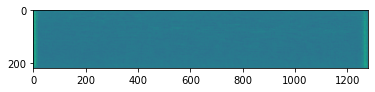

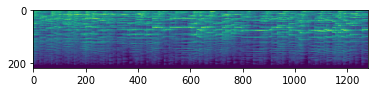

In [10]:
#CHECK - plot starting point and real recording

y = y.detach().cpu().numpy().reshape(y.size(2),y.size(3))
spect = spect.detach().cpu().numpy().reshape(spect.size(2),spect.size(3))
var = var.cpu().numpy()
mean = mean.cpu().numpy()
spect = spect*var+mean
y = y*var+mean
plt.imshow(y)
plt.show()
plt.imshow(spect)


In [11]:
#TRAIN PARAMETERS

num_epochs = 1000
batch_size = 3
num_workers = 0
# make train and valid splits

random.seed(0)  # rng seed, set to 0 for reproducibility

dataset_indices = list(range(len(dataset)))
random.shuffle(dataset_indices)  # shuffle the indices before splitting (use random.shuffle)

#split datasets
train_split_indices = dataset_indices[:int(len(dataset_indices)*0.8)]  # get the training split indices
#valid_split_indices = dataset_indices[int(len(dataset_indices)*0.6):int(len(dataset_indices)*0.8)]  # get the validation split indices 
#test_split_indices = dataset_indices[int(len(dataset_indices)*0.8):]

train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_split_indices)
#valid_subset_sampler = torch.utils.data.SubsetRandomSampler(valid_split_indices)
#test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_split_indices)

train_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, sampler=train_subset_sampler, num_workers=num_workers, drop_last=True)


d_learning_rate=0.0001
g_learning_rate=0.0001
g_optimizer = torch.optim.Adam(generator.parameters(),lr=d_learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(),lr=g_learning_rate)
g_optim_sch = torch.optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, mode='min', factor=1.0/3.16227766, patience=5,verbose=True, threshold=0.0001, threshold_mode='rel',cooldown=0, min_lr=0, eps=1e-08)
d_optim_sch = torch.optim.lr_scheduler.ReduceLROnPlateau(d_optimizer, mode='min', factor=1.0/3.16227766, patience=5,verbose=True, threshold=0.0001, threshold_mode='rel',cooldown=0, min_lr=0, eps=1e-08)


n_disc = 5 
    

C:\Anaconda\envs\psiml_gpu\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


loss_disc= 5.404756546020508
loss_gen =  7.857543468475342


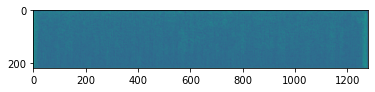

Epoch:  0
loss_disc= 5.025402545928955
loss_gen =  5.839539051055908


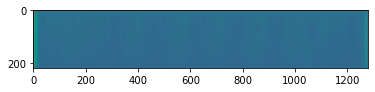

Epoch:  1
loss_disc= 5.758312225341797
loss_gen =  5.104111194610596


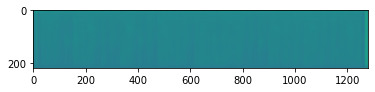

Epoch:  2
loss_disc= 5.203434944152832
loss_gen =  5.641635894775391


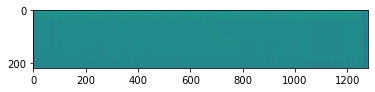

Epoch:  3
loss_disc= 4.568772315979004
loss_gen =  4.4089531898498535


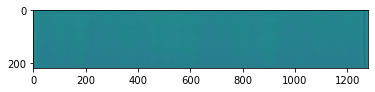

Epoch:  4
loss_disc= 4.611551284790039
loss_gen =  4.499408721923828


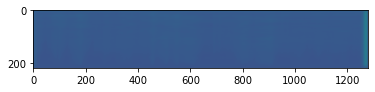

Epoch:  5
loss_disc= 4.783812046051025
loss_gen =  5.330069065093994


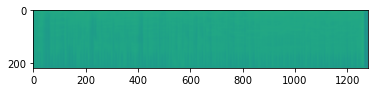

Epoch:  6
loss_disc= 4.4932146072387695
loss_gen =  5.200539588928223


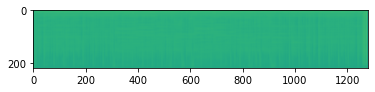

Epoch:  7
loss_disc= 5.812817096710205
loss_gen =  4.345539569854736


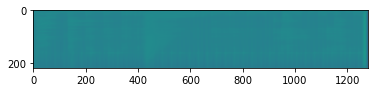

Epoch:  8
loss_disc= 4.382500648498535
loss_gen =  5.178277015686035


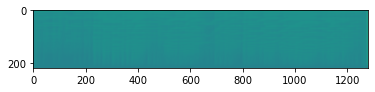

In [ ]:
#TRAIN GAN

lambda_class_d = 5 #parameter for the "importance" of good classification
lambda_class = 5
lambda_cycle = 5
lambda_ident = 5
#TODO: parametri wtf


for epoch in range(num_epochs):
    
    for i, (name,spect,mean,var,label) in enumerate(train_dataloader):
        
        discriminator = discriminator.train()
        generator = generator.train()
        
        #get labels (c) and convert to onehot
        label_goal = []
        rnd_label = []
        label_onehot = []
        for j in range(batch_size):
            rnd_label.append(random.randint(0,len(dataset.classes)-1))
            label_goal.append(np.zeros(len(dataset.classes)))
            label_goal[j][rnd_label[j]] = 1
            
            label_onehot.append(np.zeros(len(dataset.classes)))
            label_onehot[j][label[j]] = 1
        #print(label)
        #print(label_onehot)
        label_goal = torch.Tensor(label_goal) 
        label_onehot = torch.Tensor(label_onehot)
        
        #print('ucitao labele=',label_goal)
        
        label = label.type(torch.LongTensor)
        rnd_label = torch.Tensor(rnd_label)
        rnd_label = rnd_label.type(torch.LongTensor)
        
        label = label.to(device)
        rnd_label = rnd_label.to(device)
        label_onehot = label_onehot.to(device)
        label_goal = label_goal.to(device)
        spect = spect.to(device)
        
        #print('prebaceno na device\n')
        
        #train discriminator
        genre,fake = discriminator(spect)
        loss_real = - torch.mean(fake)
        loss_class = F.cross_entropy(genre, label)
        
        #print('prosao kroz jedan discr\n')
        #print(label_goal)
        generator_out = generator(spect,label_goal)
            
        #print('prosao kroz gen\n')
        genre, fake = discriminator(generator_out.detach())
        loss_fake = torch.mean(fake)
        
        #TODO: add gradient penalty 
        
        loss_disc = loss_real + loss_fake + lambda_class_d * loss_class
        
        d_optimizer.zero_grad()
        loss_disc.backward()
        d_optimizer.step()
        #if (i%10==0):
            #print("loss_real=",loss_real.item())
            #print("loss_disc=",loss_disc.item())
            #print('Loss disc: ',loss_gen.item())
            #print('Genre,fake=',genre,fake)
        #train generator
        if (i % n_disc == 0 and epoch>-1):
            generator_out = generator(spect,label_goal)
            genre,fake = discriminator(generator_out)
            loss_fake = - torch.mean(fake) #adversary loss
            loss_class = F.cross_entropy(genre, rnd_label) #wrong class
            
            self_inverse = generator(generator_out,label_onehot)
            loss_cycle = torch.mean(torch.abs(self_inverse - spect))
            
            self_out = generator(spect,label_onehot)
            loss_ident = torch.mean(torch.abs(self_out - spect))
            
            loss_gen = loss_fake + lambda_class*loss_class + lambda_cycle * loss_cycle + lambda_ident * loss_ident
            
            
            g_optimizer.zero_grad()
            loss_gen.backward()
            g_optimizer.step()
            
        if(i%100 == 0 and epoch>-1):
            print("loss_disc=",loss_disc.item())
            print("loss_gen = ",loss_gen.item())
            generator_out = generator_out[0].detach().cpu().numpy().reshape(generator_out.size(2),generator_out.size(3))
            mean = mean[0].cpu().numpy()
            var = var[0].cpu().numpy()
            generator_out = var*generator_out+mean
            plt.imshow(generator_out)
            plt.show()
            
    g_optim_sch.step(loss_gen)
    d_optim_sch.step(loss_disc)
            
    print('Epoch: ',epoch)
    
    if(epoch%10==1 and epoch>30):
        generator = generator.eval()
        y = generator(spect,label_onehot).detach()
        y = y[0].detach().cpu().numpy().reshape(y.size(2),y.size(3))
        mean = mean[0].cpu().numpy()
        var = var[0].cpu().numpy()
        #print("mean=",mean," var=",var)
        dataloader.writeAudio(y,22050,mean,var,'epoch_gan1'+str(epoch))
        
        

In [ ]:
#TEST WRITE GENERATED AUDIO
import librosa
import scipy
import soundfile as sf

#get first recording
data = dataset.data[5]
spect = data[0][0]
sr = data[0][1]

#normalize
spect = spect[:,:1280] 
mean = spect.mean()
var = spect.var()
spect = (spect-mean)/var

spect = spect.reshape(1,spect.size(0),spect.size(1),spect.size(2))
spect = spect.to(device)

#desired label - currently the same
label_onehot = torch.zeros(len(dataset.classes)) 
label_onehot[0] = 1
label_onehot = label_onehot.reshape(1,-1)
label_onehot = label_onehot.to(device)

#generate
y = generator(spect,label_onehot)

#show img - our output vs real recording
y = y.detach().cpu().numpy().reshape(y.size(2),y.size(3))
spect = spect.detach().cpu().numpy().reshape(spect.size(2),spect.size(3))
plt.imshow(y)
plt.show()
plt.imshow(spect)

#write file test.wav
dataloader.writeAudio(spect, 22050,mean,var,'test')



In [ ]:
#TEST - LOAD AUDIO/WRITE AUDIO
spec,sr = dataloader.readAudio("C:\\Users\\psimluser\\Desktop\\PSIML6_Voice_style_transfer\\Data\\genres_original\\blues\\blues.00000.wav")
spect = spect[:,:1280] 
mean = spect.mean()
var = spect.var()
spect = (spect-mean)/var
dataloader.writeAudio(spect, 22050,mean,var,'meanvarselftest')
